XRF detection limits
========
Define the [materials](materials.ipynb) that could be in your sample:

In [90]:
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromname
from spectrocrunch.materials import mixture
from spectrocrunch.materials import types

components = {}
k = compoundfromname.compoundfromname("linseed oil")
components[k] = 1
k = compoundfromformula.CompoundFromFormula("Al2O3",4.02)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("SiO2",2.66)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaCO3",2.71)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaSO4(H2O)2",2.31)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("Fe3(PO4)2(H2O)8",2.65)
components[k] = 1

mix1 = mixture.Mixture(components.keys(),components.values(),\
                      types.fraction.mass,name="Mixture1")

components = {}
k = compoundfromformula.CompoundFromFormula("PbSO4",2.65)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaCl2",2.15)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CeO2",7.22)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("TiO2",4.23)
components[k] = 1

mix2 = mixture.Mixture(components.keys(),components.values(),\
                      types.fraction.mass,name="Mixture2")

Define the XRF geometry:

In [85]:
from spectrocrunch.materials import multilayer
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.sources import xray as xraysources

source = xraysources.factory("synchrotron")
detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",detectorposition=-20.,detector=detector,source=source)

Define some helper functions:

In [86]:
from spectrocrunch.materials import xrayspectrum
from spectrocrunch.common import instance

def getfluolines(ele,emin,emax):
    lines = xrayspectrum.FluoLine.factory(energybounds=(ele,emin,emax))
    return ["{}-{}".format(ele,line) for line in lines]

Create sample and estimate detection limits:

Multilayer (ordered top-bottom):
 Layer 0. 10.0 um (10.00 wt% Al2O3 + 21.25 wt% SiO2 + 21.25 wt% CaCO3 + 21.25 wt% linseed oil + 5.00 wt% CaSO4(H2O)2 + 21.25 wt% Fe3(PO4)2(H2O)8)
 Layer 1. 10.0 um (49.40 wt% CaCl2 + 50.00 wt% PbSO4 + 0.10 wt% TiO2 + 0.50 wt% CeO2)
Mixture1
C: 19.1036941009 wt%
H: 3.15874834406 wt%
Ca: 9.67313845959 wt%
Si: 9.93346588778 wt%
Al: 5.29187703938 wt%
O: 42.1862113569 wt%
P: 2.62448773631 wt%
S: 0.931331881083 wt%
Fe: 7.09704519398 wt%
Mixture2
Cl: 31.5625945946 wt%
Ca: 17.8374054054 wt%
O: 10.6843087873 wt%
Pb: 34.1615009232 wt%
S: 5.28719335268 wt%
Ce: 0.407046999361 wt%
Ti: 0.0599499374218 wt%


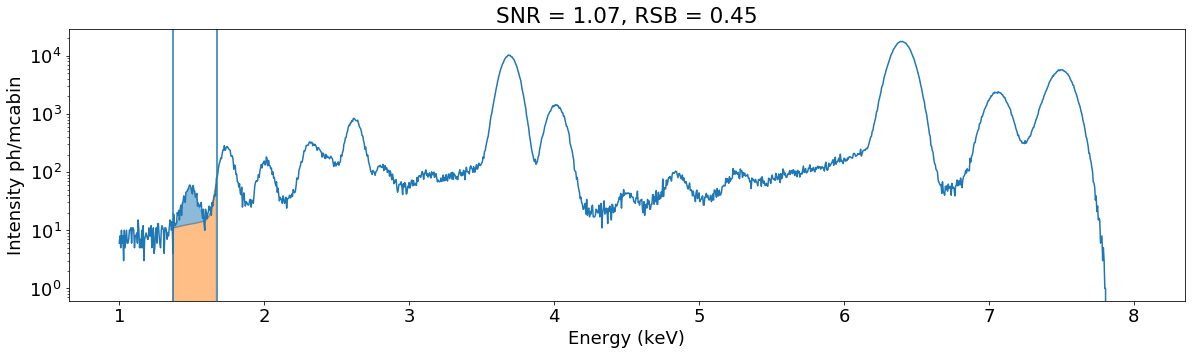

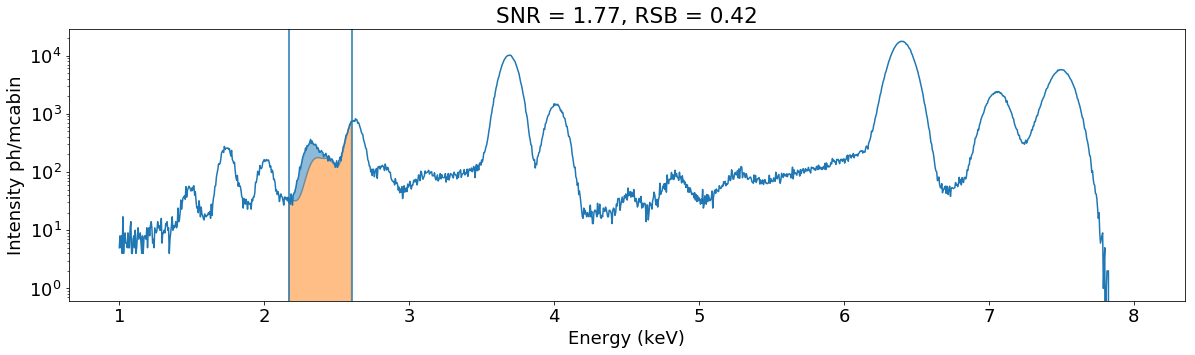

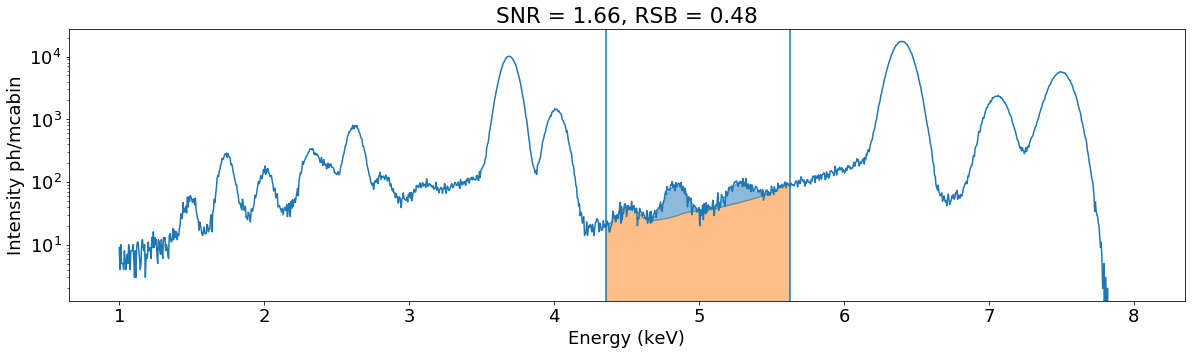

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

# Define sample and acquisition
energy = 7.5 # keV
flux = 1e10 # ph/s
time = 1 # s
t1,t2 = 10,10 # micron

sample = multilayer.Multilayer(material=[mix1,mix2],thickness=[t1*1e-4,t2*1e-4],geometry = geometry)
#lines = [["Al-K"],["S-KL"],["Ce"]]
lines = [getfluolines("Al",1,2),getfluolines("S",2,3),getfluolines("Ce",4.5,5.5)]

# Define background
detector.bstail = True
detector.bstep = True
bkgfluxmax = 10 # ph/s
bkgenergymin = 1.
bkgenergymax = bkgenergymin + (energy-bkgenergymin)*0.5
bkgenergyw = bkgfluxmax*time/(bkgenergymin-bkgenergymax)**2
backfunc = lambda x: np.clip(bkgfluxmax*time-bkgenergyw*(x-bkgenergymax)**2,0,None)
#backfunc = None

# Function to calculate + plot
def SNR(sample,lines,plotlines=False):
    if instance.isstring(lines):
        lines = [lines]
    spectrum = sample.xrayspectrum(energy,emin=1,emax=energy+0.5)
    linevalid = lambda ln: any(ln.startswith(line) for line in lines)
    ret = spectrum.snr(linevalid,fluxtime=flux*time,histogram=True,backfunc=backfunc,plot=True,kstd=3)
    
    if plotlines:
        spectrum.plot(fluxtime=flux*time,histogram=True,backfunc=backfunc,\
                  forcelines=False,title=None,legend=False,log=True)
    else:
        plt.gca().set_yscale('log', basey=10)
        
    #plt.ylim((1,1e4))
    #plt.xlim((1,3))
    return ret

# Last-minute changes in composition
#mix1.setmassfraction(["Al2O3","CaSO4(H2O)2"],[0.1,0.05,0.0001])
#mix2.setmassfraction(["PbSO4","CeO2","TiO2"],[0.5,0.005,0.001])

# Print composition
def printcomp(comp,unit="ppm"):
    if unit=="ppm":
        nfrac = comp.molefractions()
        printfmt = lambda k,v: "{}: {} ppm".format(k,v/s*1e6)
    elif unit=="wt%":
        nfrac = comp.massfractions()
        printfmt = lambda k,v: "{}: {} wt%".format(k,v/s*1e2)
    elif unit=="ug/g":
        nfrac = comp.massfractions()
        printfmt = lambda k,v: "{}: {} ug/g".format(k,v/s*1e6)
    s = sum(nfrac.values())
    print(comp.name)
    for k,v in nfrac.items():
        print(printfmt(k,v))

print(sample)
unit = "wt%"
for layer in sample:
    try:
        printcomp(layer.tocompound(name=layer.material.name),unit=unit)
    except:
        printcomp(layer.material,unit=unit)

# Calculate + plot SNR for each line
for line in lines:
    plt.figure(figsize=(20,5))
    result = SNR(sample,line,plotlines=False)
    plt.show()